In [1]:
import torchaudio
import torchaudio.functional as F
from pathlib import Path
from srmrpy import SRMR
from tqdm.auto import tqdm
import numpy as np
import torch
from shutil import copy

In [2]:
wavs = sorted(list(Path("../generated").rglob("*.wav")))
np.random.seed(42)
np.random.shuffle(wavs)

In [3]:
# max_hours = 10.
target_dir = Path("dist/baseline")
target_dir.mkdir(exist_ok=True, parents=True)
# speaker_freq = {}

# with tqdm(total=max_hours) as pbar:
#     for wav in wavs:
#         if "original" not in str(wav):
#             lab = Path(str(wav).replace(".wav", ".lab"))
#             meta = Path(str(wav).replace(".wav", ".meta"))
#             speaker_dir = target_dir / wav.parent.name
#             speaker_dir.mkdir(exist_ok=True, parents=True)
#             copy(wav, speaker_dir / wav.name)
#             copy(lab, speaker_dir / lab.name)
#             copy(meta, speaker_dir / meta.name)
#             audio, fs = torchaudio.load(wav)
#             hours = len(audio[0]) / fs / 3600
#             pbar.update(hours)
#             if pbar.n >= max_hours:
#                 break

In [4]:
wavs = list(target_dir.rglob("*.wav"))
original_path = Path("../data/train-clean-b")
results = {
    "real": {},
    "synth": {},
}

In [5]:
fs = 16_000
srmr = SRMR(fs)

num_samples = 0
r_srmr = []
s_srmr = []
r_len = 0
s_len = 0

max_hours = 10

with tqdm(total=max_hours) as pbar:
    for wav in wavs:
        if "original" not in str(wav):
            synth = wav
            real = original_path / wav.parent.name / wav.name
            s_audio, s_fs = torchaudio.load(synth)
            r_audio, r_fs = torchaudio.load(real)
            if s_fs != fs:
                s_audio = F.resample(s_audio, s_fs, fs)
            if r_fs != fs:
                r_audio = F.resample(r_audio, r_fs, fs)
            try:
                r_len = len(r_audio[0]) / fs / 3600
                s_len = len(s_audio[0]) / fs / 3600
                s_srmr_val = srmr.srmr(s_audio[0].numpy())[0]
                r_srmr_val = srmr.srmr(r_audio[0].numpy())[0]
                s_srmr.append(s_srmr_val)
                r_srmr.append(r_srmr_val)
                num_samples += 1
                pbar.update(s_len)
                if pbar.n >= max_hours:
                    break
            except:
                print(f"skipped {wav}")

STFT filter created, time used = 0.0014 seconds
Gammatone filter created, time used = 0.0014 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

/home/christoph/.pyenv/versions/3.8.13/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/christoph/.pyenv/versions/3.8.13/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


skipped dist/baseline/2531/2531_156724_000012_000001.wav


In [6]:
results["real"]["srmr"] = np.array(r_srmr)
results["synth"]["srmr"] = np.array(s_srmr)

In [7]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

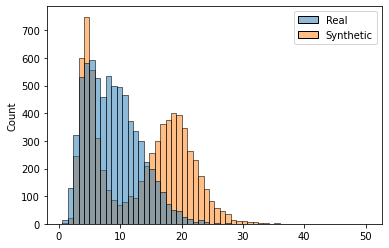

In [8]:
sns.histplot(
    x=list(results["real"]["srmr"]) + list(results["synth"]["srmr"]),
    hue=["Real"]*len(results["real"]["srmr"])+["Synthetic"]*len(results["synth"]["srmr"])
)

In [9]:
r_srmr = np.array(r_srmr)
r_srmr_norm = (r_srmr-r_srmr.mean())/r_srmr.std()
s_srmr = np.array(s_srmr)
s_srmr_norm = (s_srmr-r_srmr.mean())/r_srmr.std()

In [10]:
np.sum(np.abs(np.sort(r_srmr_norm)-np.sort(s_srmr_norm)))/len(r_srmr)

0.9755813351360271

In [11]:
np.sum(np.abs(np.array(r_srmr_norm)-np.array(s_srmr_norm)))/len(r_srmr)

1.1986733858076648

In [12]:
from wada import wada_snr

In [13]:
fs = 16_000

num_samples = 0
r_wada = []
s_wada = []
r_len = 0
s_len = 0

max_hours = 10

with tqdm(total=max_hours) as pbar:
    for wav in wavs:
        synth = wav
        real = original_path / wav.parent.name / wav.name
        s_audio, s_fs = torchaudio.load(synth)
        r_audio, r_fs = torchaudio.load(real)
        if s_fs != fs:
            s_audio = F.resample(s_audio, s_fs, fs)
        if r_fs != fs:
            r_audio = F.resample(r_audio, r_fs, fs)
        r_len = len(r_audio[0]) / fs / 3600
        s_len = len(s_audio[0]) / fs / 3600
        s_wada.append(wada_snr(s_audio[0].numpy()))
        r_wada.append(wada_snr(r_audio[0].numpy()))
        num_samples += 1
        pbar.update(s_len)
        if pbar.n >= max_hours:
            break

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
results["real"]["wada"] = np.array(r_wada)
results["synth"]["wada"] = np.array(s_wada)

<AxesSubplot:ylabel='Count'>

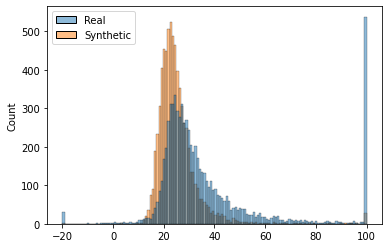

In [15]:
sns.histplot(
    x=list(results["real"]["wada"]) + list(results["synth"]["wada"]),
    hue=["Real"]*len(results["real"]["wada"])+["Synthetic"]*len(results["synth"]["wada"])
)

In [16]:
r_wada_a = np.array(results["real"]["wada"])
r_wada_norm = (r_wada_a-r_wada_a.mean())/r_wada_a.std()
s_wada_a = np.array(results["synth"]["wada"])
s_wada_norm = (s_wada-r_wada_a.mean())/r_wada_a.std()

In [17]:
np.sum(np.abs(np.sort(r_wada_norm)-np.sort(s_wada_norm)))/len(r_srmr)

0.5581200005981264

In [18]:
np.sum(np.abs(np.array(r_wada_norm)-np.array(s_wada_norm)))/len(r_srmr)

0.6910846431908786

In [19]:
fs = 16_000

num_samples = 0
r_len = 0
s_len = 0

r_speakers = {}
s_speakers = {}

max_hours = 10

wav2mel = torch.jit.load("models/wav2mel.pt").eval()
dvector = torch.jit.load("models/dvector.pt").eval()

def get_dvec(x, fs):
    with torch.inference_mode():
        return dvector.embed_utterance(wav2mel(x, fs)).numpy()

with tqdm(total=max_hours) as pbar:
    for wav in wavs:
        synth = wav
        real = original_path / wav.parent.name / wav.name
        if wav.parent.name not in s_speakers:
            s_speakers[wav.parent.name] = []
            r_speakers[wav.parent.name] = []
        s_audio, s_fs = torchaudio.load(synth)
        r_audio, r_fs = torchaudio.load(real)
        if s_fs != fs:
            s_audio = F.resample(s_audio, s_fs, fs)
        if r_fs != fs:
            r_audio = F.resample(r_audio, r_fs, fs)
        r_len = len(r_audio[0]) / fs / 3600
        s_len = len(s_audio[0]) / fs / 3600
        try:
            s_dvec = get_dvec(s_audio, fs)
            r_dvec = get_dvec(r_audio, fs)
            s_speakers[wav.parent.name].append(s_dvec)
            r_speakers[wav.parent.name].append(r_dvec)
            num_samples += 1
            pbar.update(s_len)
            if pbar.n >= max_hours:
                break
        except:
            pass

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_6883/2936477886.py:17: UserWarning: concrete shape for linear input & weight are required to decompose into matmul + bias (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:2077.)
  return dvector.embed_utterance(wav2mel(x, fs)).numpy()


In [20]:
r_speaker_mean = [np.mean(v, axis=0) for k, v in r_speakers.items()]
s_speaker_mean = [np.mean(v, axis=0) for k, v in s_speakers.items()]

In [21]:
from sklearn.decomposition import PCA

<AxesSubplot:>

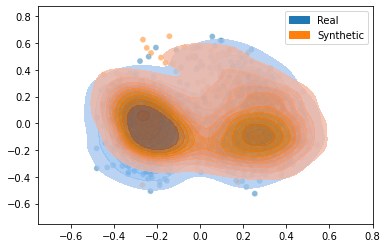

In [22]:
pca = PCA(n_components=2)
r_pcs = pca.fit_transform(r_speaker_mean)
s_pcs = pca.transform(s_speaker_mean)
sns.scatterplot(x=list(r_pcs[:, 0])+list(s_pcs[:, 0]), y=list(r_pcs[:, 1])+list(s_pcs[:, 1]), hue=["Real"]*len(r_pcs)+["Synthetic"]*len(s_pcs), alpha=0.5)
sns.kdeplot(x=list(r_pcs[:, 0])+list(s_pcs[:, 0]), y=list(r_pcs[:, 1])+list(s_pcs[:, 1]), hue=["Real"]*len(r_pcs)+["Synthetic"]*len(s_pcs), fill=True, alpha=0.75, thresh=0.05)

In [23]:
results["real"]["pc1_inter"] = r_pcs[:, 0]
results["synth"]["pc1_inter"] = s_pcs[:, 0]
results["real"]["pc2_inter"] = r_pcs[:, 1]
results["synth"]["pc2_inter"] = s_pcs[:, 1]

In [24]:
for var in ["pc1_inter", "pc2_inter"]:
    mu, std = results["real"][var].mean(), results["real"][var].std()
    norm_real = (results["real"][var]-mu)/std
    norm_synth = (results["synth"][var]-mu)/std
    mae = np.sum(np.abs(np.sort(norm_real)-np.sort(norm_synth)))/len(r_srmr)
    w = np.sum(np.abs(np.array(norm_real)-np.array(norm_synth)))/len(r_srmr)
    print(var, "mae", mae)
    print(var, "w", w)

pc1_inter mae 0.008233259826753879
pc1_inter w 0.02905732355814946
pc2_inter mae 0.011656876317386105
pc2_inter w 0.043757910941747045


In [25]:
pca = PCA(n_components=1)
r_pcs_1 = pca.fit_transform(r_speaker_mean)
s_pcs_1 = pca.transform(s_speaker_mean)

In [26]:
mu, std = r_pcs_1.mean(), r_pcs_1.std()
norm_real = (r_pcs_1-mu)/std
norm_synth = (s_pcs_1-mu)/std
mae = np.sum(np.abs(np.sort(norm_real)-np.sort(norm_synth)))/len(r_srmr)
w = np.sum(np.abs(np.array(norm_real)-np.array(norm_synth)))/len(r_srmr)
mae, w

(0.029057520768962265, 0.029057520768962265)

In [27]:
r_pcs_1 = [x[0] for x in r_pcs_1]
s_pcs_1 = [x[0] for x in s_pcs_1]

<AxesSubplot:ylabel='Count'>

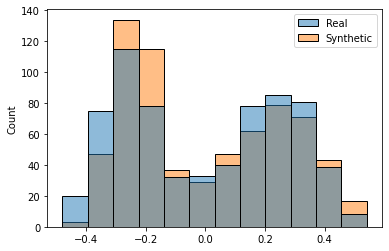

In [28]:
sns.histplot(x=list(r_pcs_1) + list(s_pcs_1), hue=["Real"]*len(r_pcs_1)+["Synthetic"]*len(s_pcs_1))

In [29]:
r_speaker_intra = []
s_speaker_intra = []
for k, v in r_speakers.items():
    for dvec in v:
        r_speaker_intra.append(dvec-np.mean(v, axis=0))
for k, v in s_speakers.items():
    for dvec in v:
        s_speaker_intra.append(dvec-np.mean(v, axis=0))

<AxesSubplot:>

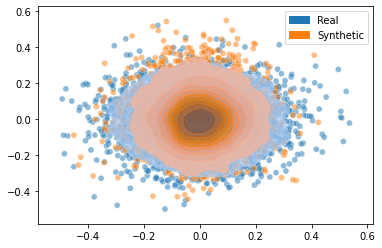

In [30]:
pca = PCA(n_components=2)
r_pcs = pca.fit_transform(r_speaker_intra)
s_pcs = pca.transform(s_speaker_intra)
sns.scatterplot(x=list(r_pcs[:, 0])+list(s_pcs[:, 0]), y=list(r_pcs[:, 1])+list(s_pcs[:, 1]), hue=["Real"]*len(r_pcs)+["Synthetic"]*len(s_pcs), alpha=0.5)
sns.kdeplot(x=list(r_pcs[:, 0])+list(s_pcs[:, 0]), y=list(r_pcs[:, 1])+list(s_pcs[:, 1]), hue=["Real"]*len(r_pcs)+["Synthetic"]*len(s_pcs), fill=True, alpha=0.75, thresh=0.05)

In [31]:
results["real"]["pc1_intra"] = r_pcs[:, 0]
results["synth"]["pc1_intra"] = s_pcs[:, 0]
results["real"]["pc2_intra"] = r_pcs[:, 1]
results["synth"]["pc2_intra"] = s_pcs[:, 1]

In [32]:
for var in ["pc1_intra", "pc2_intra"]:
    mu, std = results["real"][var].mean(), results["real"][var].std()
    norm_real = (results["real"][var]-mu)/std
    norm_synth = (results["synth"][var]-mu)/std
    mae = np.sum(np.abs(np.sort(norm_real)-np.sort(norm_synth)))/len(r_srmr)
    w = np.sum(np.abs(np.array(norm_real)-np.array(norm_synth)))/len(r_srmr)
    print(var, "mae", mae)
    print(var, "w", w)

pc1_intra mae 0.2196668776842287
pc1_intra w 0.8361136613170008
pc2_intra mae 0.08613853691652808
pc2_intra w 1.0298714515605771


In [33]:
np.sum(np.abs(np.sort(r_srmr_norm)-np.sort(s_srmr_norm)))/len(r_srmr)

0.9755813351360271

In [34]:
np.sum(np.abs(np.array(r_srmr_norm)-np.array(s_srmr_norm)))/len(r_srmr)

1.1986733858076648

In [35]:
import pyworld as pw

def get_f0(x, fs):
    _f0, t = pw.dio(x, fs)    # raw pitch extractor
    f0 = pw.stonemask(x, _f0, t, fs)
    return np.mean(f0)

In [36]:
fs = 16_000

num_samples = 0
r_wada = []
s_wada = []
r_len = 0
s_len = 0

max_hours = 10

with tqdm(total=max_hours) as pbar:
    for wav in wavs:
        synth = wav
        real = original_path / wav.parent.name / wav.name
        s_audio, s_fs = torchaudio.load(synth)
        r_audio, r_fs = torchaudio.load(real)
        if s_fs != fs:
            s_audio = F.resample(s_audio, s_fs, fs)
        s_audio = s_audio / s_audio.max()
        if r_fs != fs:
            r_audio = F.resample(r_audio, r_fs, fs)
        r_audio = r_audio / r_audio.max()
        r_len = len(r_audio[0]) / fs / 3600
        s_len = len(s_audio[0]) / fs / 3600
        s_wada.append(get_f0(s_audio[0].numpy().astype("double"), fs))
        r_wada.append(get_f0(r_audio[0].numpy().astype("double"), fs))
        num_samples += 1
        pbar.update(s_len)
        if pbar.n >= max_hours:
            break

  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
results["real"]["f0"] = np.array(r_wada)
results["synth"]["f0"] = np.array(s_wada)

In [38]:
for var in ["f0"]:
    mu, std = results["real"][var].mean(), results["real"][var].std()
    norm_real = (results["real"][var]-mu)/std
    norm_synth = (results["synth"][var]-mu)/std
    mae = np.sum(np.abs(np.sort(norm_real)-np.sort(norm_synth)))/len(r_srmr)
    w = np.sum(np.abs(np.array(norm_real)-np.array(norm_synth)))/len(r_srmr)
    print(var, "mae", mae)
    print(var, "w", w)

f0 mae 0.37336150078279473
f0 w 0.6007628755489884


<AxesSubplot:ylabel='Count'>

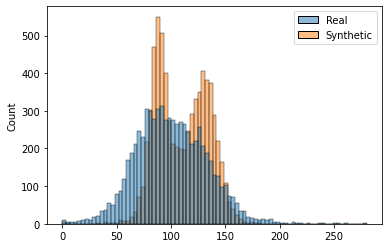

In [39]:
sns.histplot(x=list(results["real"]["f0"]) + list(results["synth"]["f0"]), hue=["Real"]*len(results["real"]["f0"])+["Synthetic"]*len(results["synth"]["f0"]))

In [40]:
fs = 16_000

num_samples = 0
r_eng = []
s_eng = []
r_len = 0
s_len = 0

max_hours = 10

with tqdm(total=max_hours) as pbar:
    for wav in wavs:
        synth = wav
        real = original_path / wav.parent.name / wav.name
        s_audio, s_fs = torchaudio.load(synth)
        r_audio, r_fs = torchaudio.load(real)
        if s_fs != fs:
            s_audio = F.resample(s_audio, s_fs, fs)
        s_audio = s_audio / s_audio.max()
        if r_fs != fs:
            r_audio = F.resample(r_audio, r_fs, fs)
        r_audio = r_audio / r_audio.max()
        r_len_s = len(r_audio[0]) / fs
        s_len_s = len(s_audio[0]) / fs
        r_energy = np.mean([np.sqrt(np.sum(x.numpy()**2)) for x in np.array_split(r_audio[0], r_len_s * 50)])
        s_energy = np.mean([np.sqrt(np.sum(x.numpy()**2)) for x in np.array_split(s_audio[0], r_len_s * 50)])
        r_len = r_len_s / 3600
        s_len = s_len_s / 3600                    
        s_eng.append(s_energy)
        r_eng.append(r_energy)
        num_samples += 1
        pbar.update(s_len)
        if pbar.n >= max_hours:
            break

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
results["real"]["e"] = np.array(r_eng)
results["synth"]["e"] = np.array(s_eng)

<AxesSubplot:ylabel='Count'>

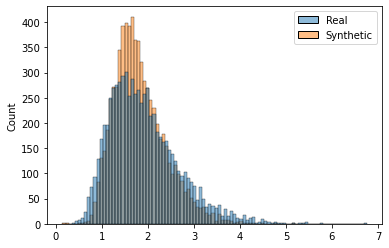

In [42]:
sns.histplot(
    x=list(results["real"]["e"]) + list(results["synth"]["e"]),
    hue=["Real"]*len(results["real"]["e"])+["Synthetic"]*len(results["synth"]["e"])
)

In [43]:
for var in ["e"]:
    mu, std = results["real"][var].mean(), results["real"][var].std()
    norm_real = (results["real"][var]-mu)/std
    norm_synth = (results["synth"][var]-mu)/std
    mae = np.sum(np.abs(np.sort(norm_real)-np.sort(norm_synth)))/len(r_srmr)
    w = np.sum(np.abs(np.array(norm_real)-np.array(norm_synth)))/len(r_srmr)
    print(var, "mae", mae)
    print(var, "w", w)

e mae 0.2024056521719983
e w 0.7179619790198704


In [44]:
import textgrid
import pickle

In [45]:
fs = 16_000

num_samples = 0
r_dur = []
s_dur = []
r_len = 0
s_len = 0

max_hours = 10

real_sampling_rate = 22050
real_hop_length = 256

with tqdm(total=max_hours) as pbar:
    for wav in wavs:
        synth = wav
        real = original_path / wav.parent.name / wav.name
        real_tgt = real.with_suffix(".TextGrid")
        tg = textgrid.TextGrid.fromFile(real_tgt)
        durations = []
        for phone in tg[1]:
            if phone.mark.strip() != "":
                durations.append(int((phone.maxTime - phone.minTime) * real_sampling_rate / real_hop_length))
        meta = pickle.load(open(synth.with_suffix(".meta"), "rb"))
        meta_durations = []
        for phone, dur in zip(meta['phones'][0].numpy(), meta['durations'][0].numpy()):
            if phone > 6:
                meta_durations.append(dur)
        assert len(durations) == len(meta_durations)
        s_audio, s_fs = torchaudio.load(synth)
        r_audio, r_fs = torchaudio.load(real)
        if s_fs != fs:
            s_audio = F.resample(s_audio, s_fs, fs)
        s_audio = s_audio / s_audio.max()
        if r_fs != fs:
            r_audio = F.resample(r_audio, r_fs, fs)
        r_audio = r_audio / r_audio.max()
        r_len_s = len(r_audio[0]) / fs
        s_len_s = len(s_audio[0]) / fs
        r_len = r_len_s / 3600
        s_len = s_len_s / 3600                    
        r_dur.append(np.mean(durations))
        s_dur.append(np.mean(meta_durations))
        num_samples += 1
        pbar.update(s_len)
        if pbar.n >= max_hours:
            break

  0%|          | 0/10 [00:00<?, ?it/s]

In [46]:
results["real"]["d"] = np.array(r_dur)
results["synth"]["d"] = np.array(s_dur)

<AxesSubplot:ylabel='Count'>

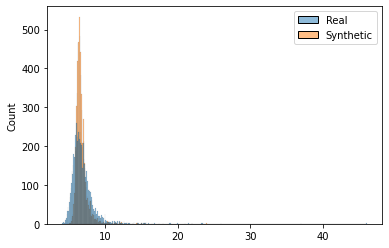

In [47]:
sns.histplot(
    x=list(results["real"]["d"]) + list(results["synth"]["d"]),
    hue=["Real"]*len(results["real"]["d"])+["Synthetic"]*len(results["synth"]["d"])
)

In [48]:
for var in ["d"]:
    mu, std = results["real"][var].mean(), results["real"][var].std()
    norm_real = (results["real"][var]-mu)/std
    norm_synth = (results["synth"][var]-mu)/std
    mae = np.sum(np.abs(np.sort(norm_real)-np.sort(norm_synth)))/len(r_srmr)
    w = np.sum(np.abs(np.array(norm_real)-np.array(norm_synth)))/len(r_srmr)
    print(var, "mae", mae)
    print(var, "w", w)

d mae 0.2970677244820577
d w 0.47809321569433855


In [49]:
for var in results["real"].keys():
    mu, std = results["real"][var].mean(), results["real"][var].std()
    norm_real = (results["real"][var]-mu)/std
    norm_synth = (results["synth"][var]-mu)/std
    mae = np.sum(np.abs(np.sort(norm_real)-np.sort(norm_synth)))/len(r_srmr)
    w = np.sum(np.abs(np.array(norm_real)-np.array(norm_synth)))/len(r_srmr)
    print(var, "mae", mae)
    print(var, "w", w)

srmr mae 0.9755813351360271
srmr w 1.1986733858076648
wada mae 0.5581200005981264
wada w 0.6910846431908786
pc1_inter mae 0.008233259826753879
pc1_inter w 0.02905732355814946
pc2_inter mae 0.011656876317386105
pc2_inter w 0.043757910941747045
pc1_intra mae 0.2196668776842287
pc1_intra w 0.8361136613170008
pc2_intra mae 0.08613853691652808
pc2_intra w 1.0298714515605771
f0 mae 0.37336150078279473
f0 w 0.6007628755489884
e mae 0.2024056521719983
e w 0.7179619790198704
d mae 0.2970677244820577
d w 0.47809321569433855


In [50]:
results

{'real': {'srmr': array([13.98927287, 11.86652592, 11.40171187, ..., 12.49584982,
         14.30399955, 10.03420812]),
  'wada': array([22.57497484, 19.66457395, 57.57474239, ..., 29.8892214 ,
         27.80591168, 28.47415915]),
  'pc1_inter': array([ 2.56478095e-01,  3.24121786e-01,  3.49764864e-01, -3.07793536e-01,
          4.15060379e-01, -2.69630391e-01,  2.09646342e-01,  3.32945498e-01,
         -2.45930092e-01, -4.11906734e-01, -3.51359387e-01, -1.06951211e-01,
          3.65464871e-01,  1.26789066e-01, -2.27348705e-01,  2.31820720e-01,
          1.03907309e-02, -2.49162768e-01, -2.06266984e-01, -2.05073187e-01,
          1.67671368e-01,  2.70766338e-01, -3.62962824e-01, -1.68672518e-03,
         -1.64748679e-01, -1.59994364e-01,  8.75063824e-02,  2.83669323e-01,
          2.46013345e-02,  1.97539300e-01, -2.22181261e-01,  3.63926360e-01,
         -4.23452050e-01,  2.54494387e-01,  3.95776159e-02,  2.69189322e-01,
          2.82950047e-01, -3.34768532e-01,  2.33174574e-01, -1.6

In [51]:
import pickle
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)

In [53]:
with open("results.pkl", "rb") as f:
    res = pickle.load(f)